In [1]:
import tensorflow as tf
import numpy as np
import pickle
import time

## import VGG16 architecture and weights
Please refer to build_model_get_weight.py for details. That python script load the weights from vgg_face.mat file. Since this is a transfer learning task, I need to use the pre-trained Conv layers as feature extractor and rewrite the last several fully connected layers, which served as a classifier, to do the classification. In order to do this binary classification for human gender, I need to downsize the output to two. Normally for vgg, the first fully connected layer will downsize feature vector to 4096, so I did the same thing. Then another fc layer downsize it to 512, and finally downsize to 2. Dropout layers are introduced to reduce overfitting.

In [2]:
from build_model_get_weight import get_vgg16

## load packed training and validation data
Please refer to pack_data.py for details. I wrote this to pack image files into binary pickle files for better performance in data reading stage. Resizing the image to (224,224,3) to fit the input of VGG16 is also include in that script.

In [3]:
train = []
val = []
with open('train.pickle', 'rb') as f:
    train += pickle.load(f)
with open('val.pickle', 'rb') as f:
    val += pickle.load(f)
train = np.array(train)
val = np.array(val)

## print out the shape of the dataset to see if it is correctly read

In [4]:
print(train.shape)
print(val.shape)

(28937, 2)
(500, 2)


## Define hyperparameters
One thing to notice is that since VGG16 is a relatively big and deep model, I have encounter with the problem of running out of memory when allocating, so I choose a small batch size.

In [5]:
# learning rate
lr = 0.00005
# number of training epochs
epochs = 10
# number of batch_size
batch_size = 32
total_batch = int(28937/batch_size)
num_steps = (epochs+1) * total_batch
num_classes = 2
W = 224
H = 224
channel = 3

## Placeholder

In [6]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,W, H, channel],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')
training = tf.placeholder_with_default(False, shape=())

## Loss and Optimization

In [7]:
logits = get_vgg16(X)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## A function to get batch for training and validation

In [8]:
def get_batch(i, size, data):
    inp = [inp[0] for inp in data[(i * size):((i + 1) * size)]]
    label = [lab[1] for lab in data[(i * size):((i + 1) * size)]]
    X_inp = np.empty((len(inp), 224, 224, 3), dtype=np.float32)
    y_label = np.empty((len(inp),2), dtype=np.float32)
    for j in range(len(inp)):
        X_inp[j] = inp[j]
        y_label[j] = label[j]
    return (X_inp, y_label)

## Training
All the print functions commented here are used for debugging. They help me see if the network is working properly.

In [9]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        start = time.time()
        for j in range(total_batch):
            # print('Feeding epoch', i, 'batch', j)
            batch_x, batch_y = get_batch(j, batch_size,train)
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y, training:True})
            # tr_acc = sess.run(accuracy, feed_dict={X: batch_x, Y: batch_y})
            # print("batch " + str(i) + ", Training accuracy= {:.3f}".format(tr_acc))
            if j == total_batch - 1:
                tr_acc = sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y})
                print("Epoch "+str(i+1)+", Training accuracy= {:.3f}".format(tr_acc))
        acc = 0
        for j in range(20):
            val_x, val_y = get_batch(j, 25, val)
            val_acc = sess.run(accuracy,feed_dict={X:val_x, Y:val_y})
            acc += val_acc
        print("Epoch "+str(i+1)+", Validation accuracy= {:.3f}".format(acc/20))
        print("Training epoch "+str(i+1)+ " takes", int(time.time() - start), "seconds")
    save_path = saver.save(sess, 'vgg_face.ckpt')
    print("Training finished!")

Epoch 1, Training accuracy= 0.781
Epoch 1, Validation accuracy= 0.910
Training epoch 1 takes 203 seconds
Epoch 2, Training accuracy= 0.812
Epoch 2, Validation accuracy= 0.874
Training epoch 2 takes 196 seconds
Epoch 3, Training accuracy= 0.875
Epoch 3, Validation accuracy= 0.896
Training epoch 3 takes 197 seconds
Epoch 4, Training accuracy= 0.844
Epoch 4, Validation accuracy= 0.912
Training epoch 4 takes 196 seconds
Epoch 5, Training accuracy= 0.812
Epoch 5, Validation accuracy= 0.924
Training epoch 5 takes 196 seconds
Epoch 6, Training accuracy= 0.906
Epoch 6, Validation accuracy= 0.878
Training epoch 6 takes 196 seconds
Epoch 7, Training accuracy= 0.812
Epoch 7, Validation accuracy= 0.864
Training epoch 7 takes 196 seconds
Epoch 8, Training accuracy= 0.844
Epoch 8, Validation accuracy= 0.902
Training epoch 8 takes 196 seconds
Epoch 9, Training accuracy= 0.844
Epoch 9, Validation accuracy= 0.914
Training epoch 9 takes 196 seconds
Epoch 10, Training accuracy= 0.875
Epoch 10, Validation

## Inference
Use test set to do the inference. Besides accuracy and f1, I also shows ten pictures with their predicted class and ground truth class. Since opencv is using [b,g,r] while matplotlib is using [r,g,b], I rearrange the channel to give a normal display. Otherwise, images shown would be weird...

In [10]:
import matplotlib.pyplot as plt
import cv2 as cv
# GT as Pred
TP = 0 # F as F
FP = 0 # M as F
TN = 0 # M as M
FN = 0 # F as M

In [11]:
test = []
with open('test.pickle', 'rb') as f:
    test += pickle.load(f)
test_np = np.array(test)
img = test_np[:,0]
lab = test_np[:,1]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from vgg_face.ckpt


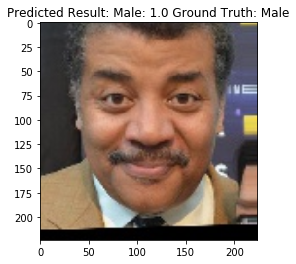

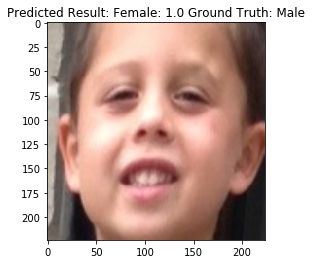

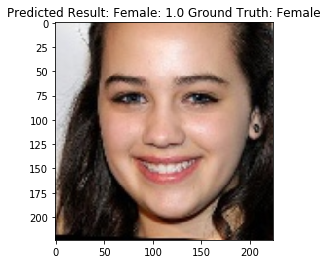

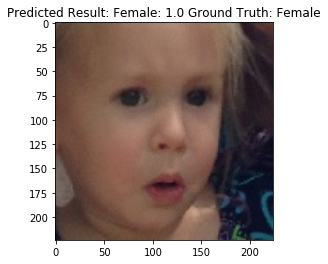

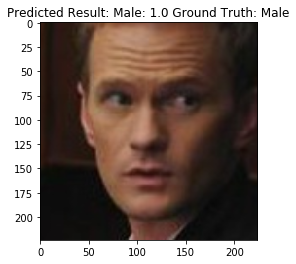

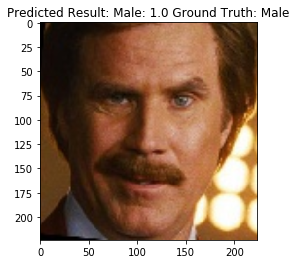

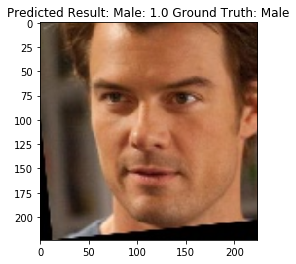

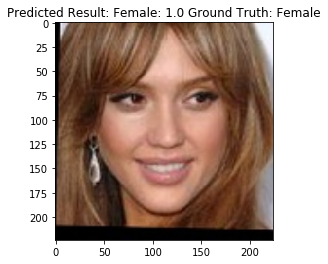

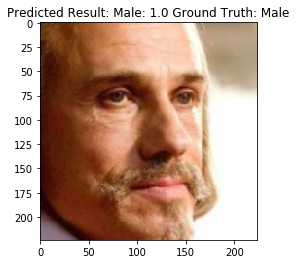

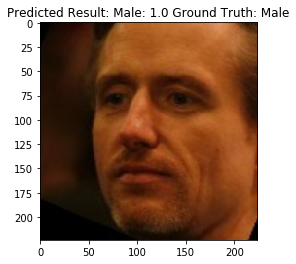

In [12]:
with tf.Session() as sess:
    saver.restore(sess, "vgg_face.ckpt")
    for i in range(len(test)):
        label = ''
        if lab[i][0] == 1:
            label = 'Female'
        else:
            label = 'Male'
        test_img, test_label = get_batch(i, 1, test)
        pred = sess.run(logits, feed_dict = {X:test_img})
        pred = np.squeeze(pred)        
        if (pred[1] < pred[0]):
            result = "Female: "+str(pred[0])
            if label == 'Female':
                TP += 1
            else:
                FP += 1        
        else:
            result = "Male: "+str(pred[1])
            if label == 'Male':
                TN += 1
            else:
                FN += 1       
        if i < 10:
            b,g,r = cv.split(img[i])  
            img[i] = cv.merge([r,g,b])  
            title = 'Predicted Result: '+result+" Ground Truth: "+label
            fig = plt.figure()
            plt.imshow(np.squeeze(img[i]))
            plt.title(title)

In [15]:
p = TP/(TP+FP)
r = TP/(TP+FN)
f1 = (2*p*r)/(p+r)
acc = (TP+TN)/(TP+FP+TN+FN)
print('Precesion:{:.3f}'.format(p),'Recall:{:.3f}'.format(r),'F1:{:.3f}'.format(f1),"Accuracy:{:.3f}".format(acc))

Precesion:0.759 Recall:0.989 F1:0.859 Accuracy:0.845
